### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import catboost
from autogluon.tabular import TabularPredictor
from modeling_pipeline import data_process, train_pipeline
from sklearn.model_selection import train_test_split

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read data and transform it accordingly

In [2]:
train = pd.read_csv("input/train.csv", parse_dates=["datetime"])
test = pd.read_csv("input/test.csv", parse_dates=["datetime"])
submission = pd.read_csv("input/sampleSubmission.csv")

In [3]:
numerical_features = [
    'temp', 'atemp', 'humidity', 'windspeed'
]

categorical_features = [
    'season', 'holiday', 'workingday', 'weather',
    'hour', 'dayofweek', 'month',
    'is_morning', 'is_evening', 'is_night',
    'temp_quart', 'atemp_quart', 'humidity_quart', 'windspeed_quart'
    ,'meteo_bin'
]

target_column = 'count'

In [4]:
train, test = data_process.numerical_to_quartiles(train, test, numerical_features)

train = data_process.enrich_featureset(train, categorical_features)
test = data_process.enrich_featureset(test, categorical_features)

train_log = data_process.create_log_transformed_data(train, target_col='count')
train_log = data_process.create_log_transformed_data(train_log, target_col='casual')
train_log = data_process.create_log_transformed_data(train_log, target_col='registered')

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_process.py:275: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


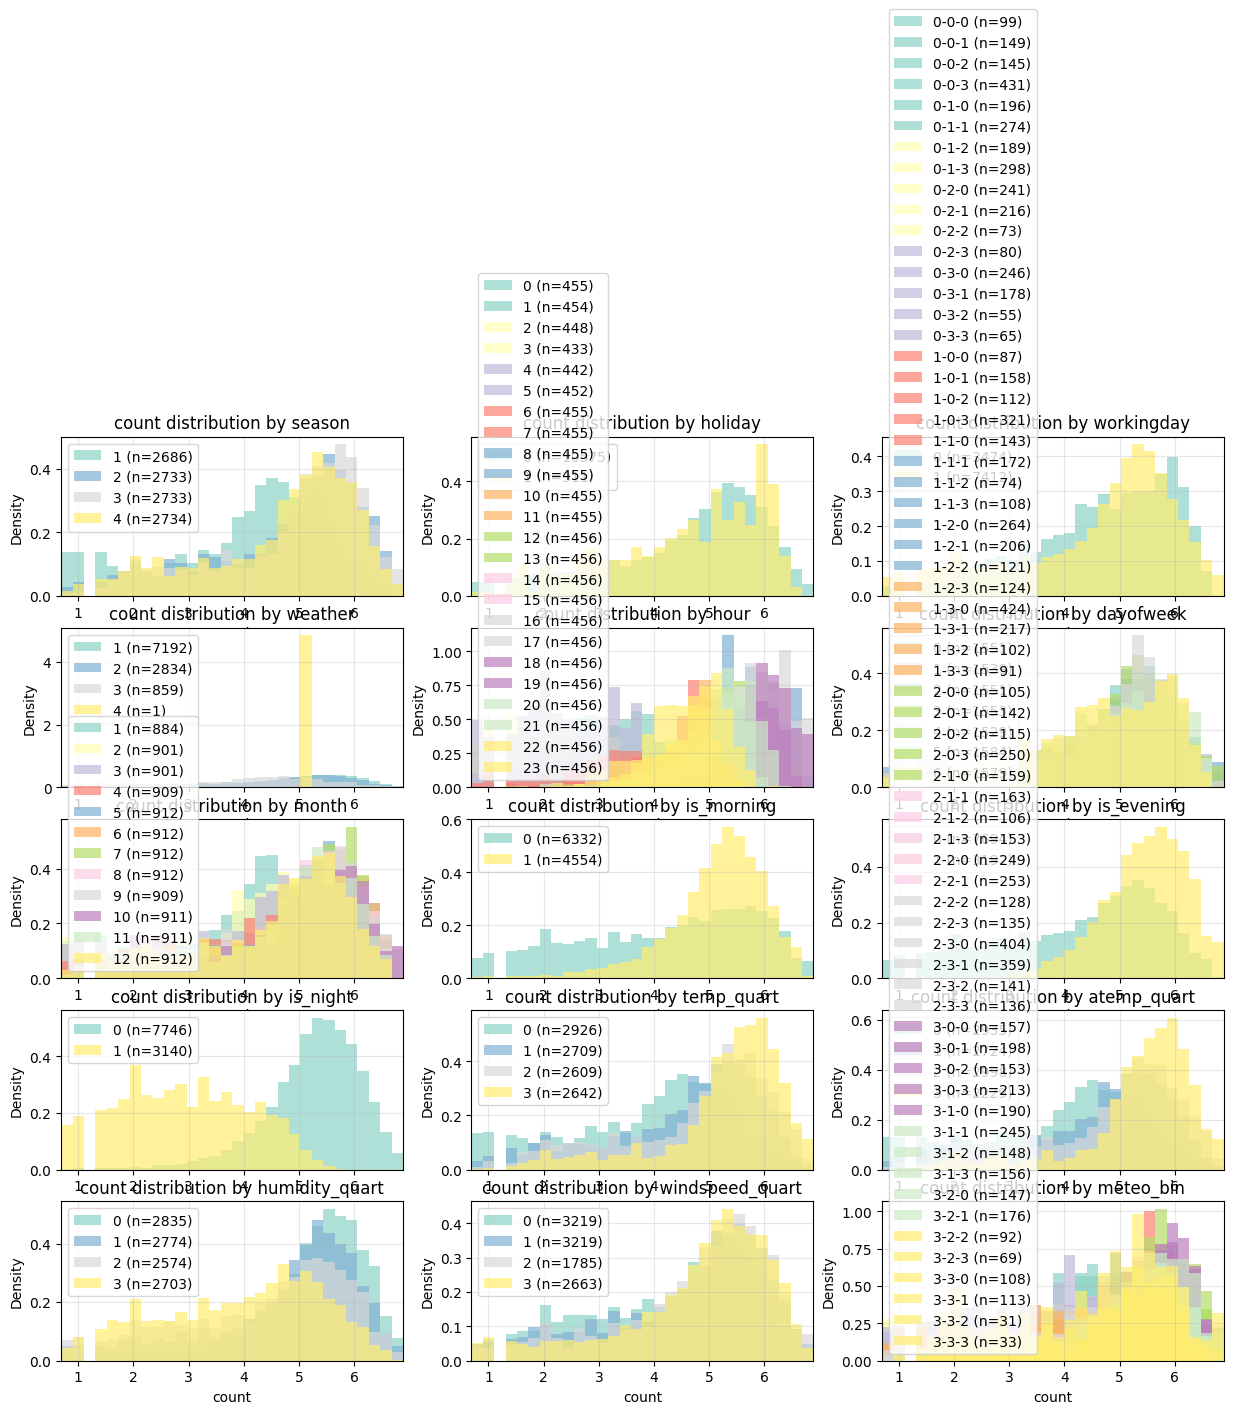

In [5]:
# Analyze target distribution across categorical features
data_process.plot_target_vs_categorical_features(
    df=train_log, 
    categorical_features=categorical_features, 
    target_col='count',
    figsize=(15, 12)
)

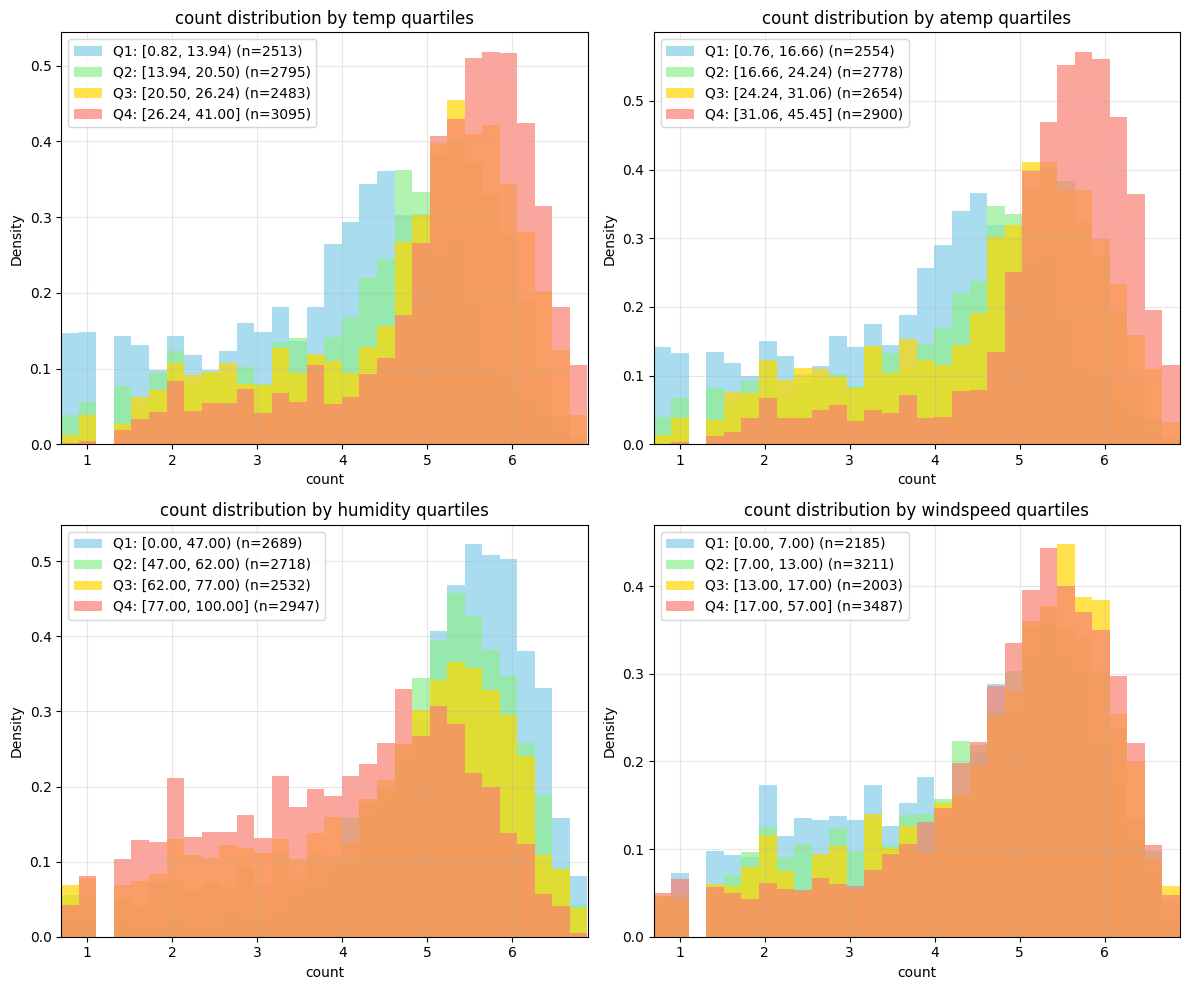

In [6]:
# Analyze target distribution across quartiles of numerical features
data_process.plot_target_vs_numerical_features_quartiles(
    df=train_log, 
    numerical_features=numerical_features, 
    target_col='count',
    figsize=(12, 10)
)

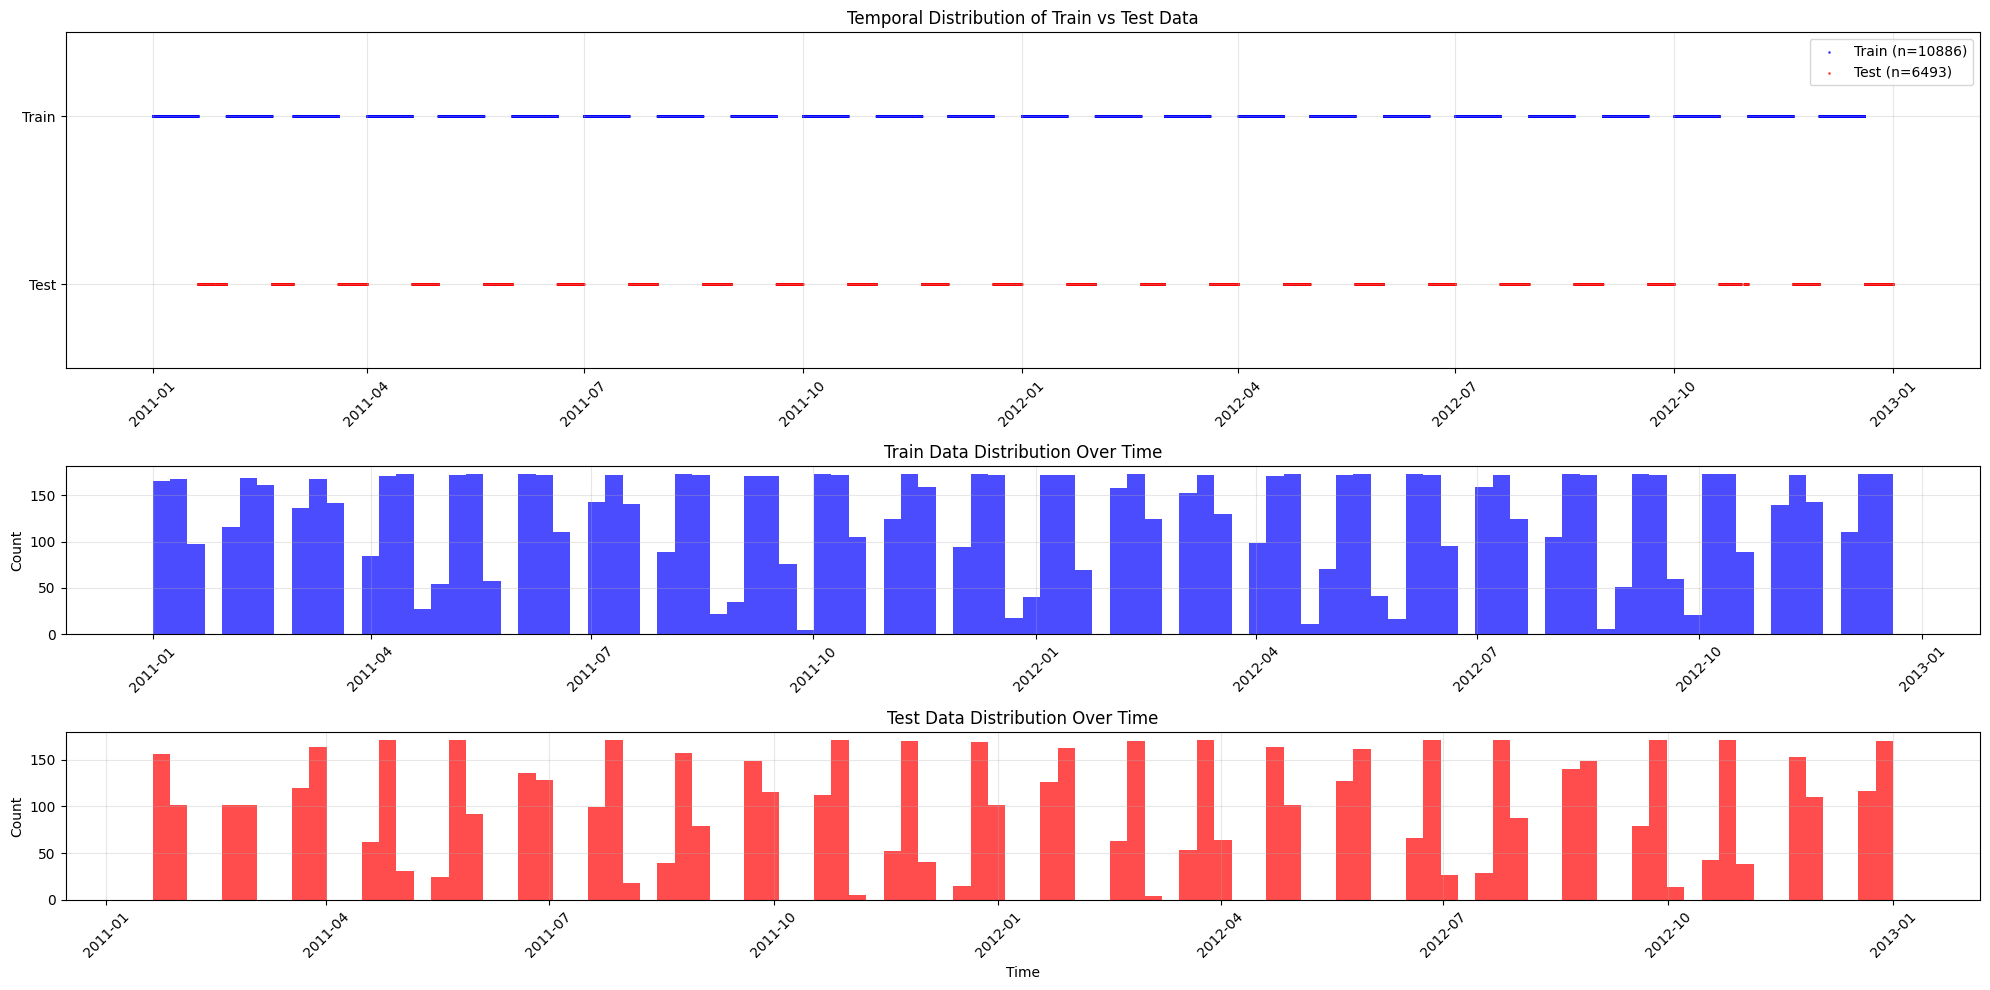

Temporal Data Summary:
Train data period: 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Test data period: 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Train duration: 718 days
Test duration: 711 days
Overlap period: 2011-01-20 00:00:00 to 2012-12-19 23:00:00
Overlap duration: 699 days
Train and test periods overlap or are adjacent


In [7]:
# Visualize temporal distribution of train vs test data
data_process.plot_temporal_data_distribution(
    train_df=train, 
    test_df=test, 
    datetime_col='datetime',
    figsize=(20, 10)
)

Temporal Coverage Analysis: 2011-10-01 to 2011-10-23
Complete time range: 552 hours
Train data points: 455
Test data points: 96
Missing hours: 1

Daily Summary:
--------------------------------------------------
2011-10-01 (Saturday):
  Train: 24 hours (100.0%)
  Test:   0 hours (  0.0%)
  Missing:  0 hours (  0.0%)

2011-10-02 (Sunday):
  Train: 24 hours (100.0%)
  Test:   0 hours (  0.0%)
  Missing:  0 hours (  0.0%)

2011-10-03 (Monday):
  Train: 24 hours (100.0%)
  Test:   0 hours (  0.0%)
  Missing:  0 hours (  0.0%)

2011-10-04 (Tuesday):
  Train: 24 hours (100.0%)
  Test:   0 hours (  0.0%)
  Missing:  0 hours (  0.0%)

2011-10-05 (Wednesday):
  Train: 24 hours (100.0%)
  Test:   0 hours (  0.0%)
  Missing:  0 hours (  0.0%)

2011-10-06 (Thursday):
  Train: 24 hours (100.0%)
  Test:   0 hours (  0.0%)
  Missing:  0 hours (  0.0%)

2011-10-07 (Friday):
  Train: 24 hours (100.0%)
  Test:   0 hours (  0.0%)
  Missing:  0 hours (  0.0%)

2011-10-08 (Saturday):
  Train: 24 hours (100

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_process.py:600: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_range = pd.date_range(start=start_dt, end=end_dt, freq='H')
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_process.py:694: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_numeric = pivot_numeric.replace({'train': 1, 'test': 2, 'missing': 0})


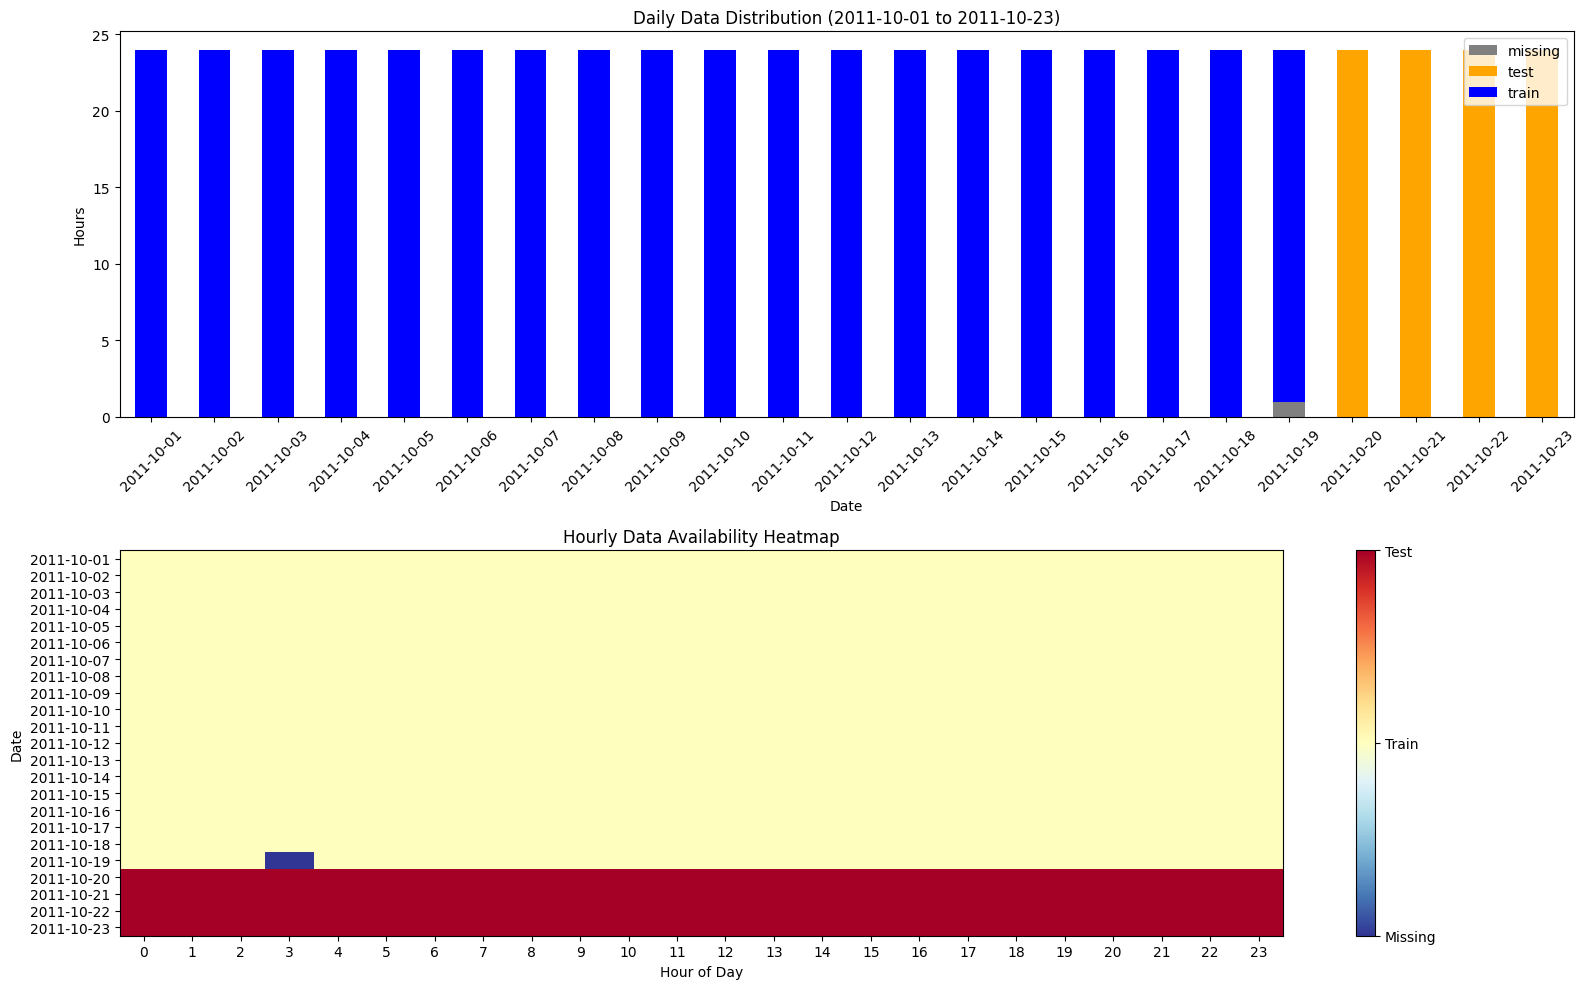

In [8]:
temporal_analysis = data_process.analyze_temporal_coverage_detailed(
    train_df=train,
    test_df=test,
    start_date='2011-10-01',
    end_date='2011-10-23',
    datetime_col='datetime'
)

### Time Lag Features

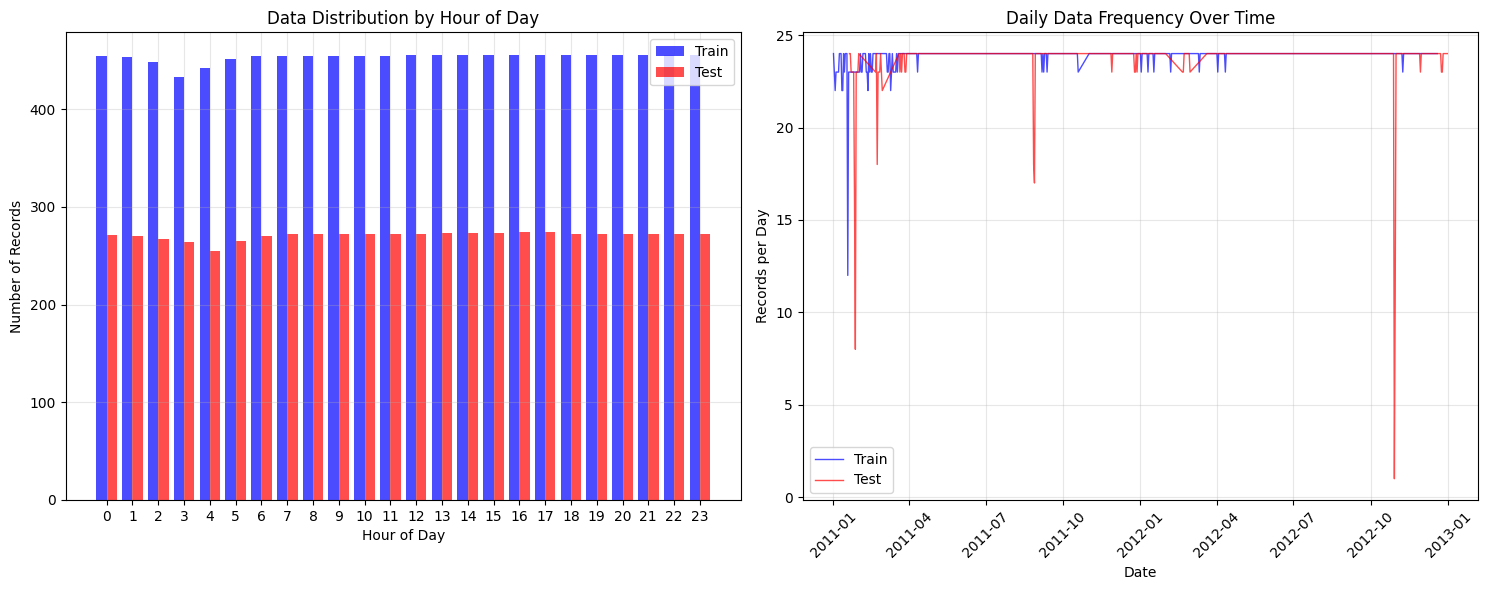

In [9]:
# Analyze hourly patterns in train vs test data
data_process.plot_hourly_patterns(
    train_df=train, 
    test_df=test, 
    datetime_col='datetime',
    figsize=(15, 6)
)

### Time Lag Features

In [10]:
### Time Lag Features

# Create log-transformed lag features using data_process functions
print("Creating log-transformed lag features...")

# Create lag features for the count target variable
train_with_log_lags, test_with_log_lags = data_process.create_log_lag_features(
    train_df=train_log, 
    test_df=test, 
    target_col='count', 
    missing_value=-999
)

# Update the datasets
train_log = train_with_log_lags.copy()
test = test_with_log_lags.copy()

# Get the lag feature names
log_lag_features = data_process.get_log_lag_feature_names()

print(f"Created {len(log_lag_features)} log lag features:")
for feature in log_lag_features:
    print(f"  - {feature}")

# Update numerical features to include lag features
numerical_features = numerical_features + log_lag_features

print(f"\nUpdated feature configuration:")
print(f"Original numerical features: {numerical_features[:4]}")
print(f"Log lag features: {log_lag_features}")
print(f"Total numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Creating log-transformed lag features...
Created 4 log lag features:
  - log_lag_1d
  - log_lag_2d
  - log_lag_7d
  - log_lag_14d

Updated feature configuration:
Original numerical features: ['temp', 'atemp', 'humidity', 'windspeed']
Log lag features: ['log_lag_1d', 'log_lag_2d', 'log_lag_7d', 'log_lag_14d']
Total numerical features: 8
Categorical features: 15


In [11]:
# Analyze lag feature coverage and correlations
data_process.analyze_lag_feature_coverage(
    df=train_log, 
    lag_features=log_lag_features, 
    title_prefix="Train "
)

data_process.analyze_lag_feature_coverage(
    df=test, 
    lag_features=log_lag_features, 
    title_prefix="Test "
)

# Calculate correlations with the target (before log transformation)
# correlations = data_process.calculate_lag_feature_correlations(
#     df=train_log, 
#     lag_features=log_lag_features, 
#     target_col='count'
# )


Train Lag Feature Coverage Analysis:
log_lag_1d:
  Available: 10,265 (94.3%)
  Missing: 621 (5.7%)
  Mean: 4.6015, Std: 1.4115

log_lag_2d:
  Available: 9,701 (89.1%)
  Missing: 1,185 (10.9%)
  Mean: 4.5991, Std: 1.4136

log_lag_7d:
  Available: 6,844 (62.9%)
  Missing: 4,042 (37.1%)
  Mean: 4.5822, Std: 1.4151

log_lag_14d:
  Available: 4,249 (39.0%)
  Missing: 6,637 (61.0%)
  Mean: 4.5983, Std: 1.3992


Test Lag Feature Coverage Analysis:
log_lag_1d:
  Available: 572 (8.8%)
  Missing: 5,921 (91.2%)
  Mean: 4.6270, Std: 1.3909

log_lag_2d:
  Available: 1,133 (17.4%)
  Missing: 5,360 (82.6%)
  Mean: 4.6407, Std: 1.3778

log_lag_7d:
  Available: 3,983 (61.3%)
  Missing: 2,510 (38.7%)
  Mean: 4.6455, Std: 1.3904

log_lag_14d:
  Available: 6,470 (99.6%)
  Missing: 23 (0.4%)
  Mean: 4.6117, Std: 1.4091



In [12]:
train_log.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,month,dayofweek,is_morning,is_evening,is_night,log_lag_1d,log_lag_2d,log_lag_7d,log_lag_14d
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,1.386294,...,0,1,5,0,0,1,-999.0,-999.0,-999.0,-999.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2.197225,...,1,1,5,0,0,1,-999.0,-999.0,-999.0,-999.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,1.791759,...,2,1,5,0,0,1,-999.0,-999.0,-999.0,-999.0


In [13]:
test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,temp_quart,...,hour,month,dayofweek,is_morning,is_evening,is_night,log_lag_1d,log_lag_2d,log_lag_7d,log_lag_14d
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,...,0,1,3,0,0,1,1.386294,-999.0,2.079442,2.484907
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,0,...,1,1,3,0,0,1,2.079442,-999.0,1.098612,1.609438
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,0,...,2,1,3,0,0,1,1.386294,-999.0,1.098612,1.098612


## Training Phase

In [14]:
print("New features created and log transformation applied!")
print(f"Train shape: {train_log.shape}")
print(f"Test shape: {test.shape}")
print(f"Log-transformed target range: {train_log['count'].min():.4f} to {train_log['count'].max():.4f}")
print(f"Log-transformed target range: {train_log['casual'].min():.4f} to {train_log['casual'].max():.4f}")
print(f"Log-transformed target range: {train_log['registered'].min():.4f} to {train_log['registered'].max():.4f}")
train_log.head(3)

New features created and log transformation applied!
Train shape: (10886, 27)
Test shape: (6493, 24)
Log-transformed target range: 0.6931 to 6.8855
Log-transformed target range: 0.0000 to 5.9081
Log-transformed target range: 0.0000 to 6.7878


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,month,dayofweek,is_morning,is_evening,is_night,log_lag_1d,log_lag_2d,log_lag_7d,log_lag_14d
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,1.386294,...,0,1,5,0,0,1,-999.0,-999.0,-999.0,-999.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2.197225,...,1,1,5,0,0,1,-999.0,-999.0,-999.0,-999.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,1.791759,...,2,1,5,0,0,1,-999.0,-999.0,-999.0,-999.0


In [15]:
full_train_log = train_log.copy()
train_log_pre, test_log = train_test_split(train_log, test_size=0.2, random_state=26)
train_log, val_log = train_test_split(train_log_pre, test_size=0.25, random_state=26) 

len(train_log), len(val_log), len(test_log)

(6531, 2177, 2178)

In [16]:
X_train_log = train_log[numerical_features + categorical_features]
y_train_log = train_log[target_column]

X_val_log = val_log[numerical_features + categorical_features]
y_val_log = val_log[target_column]

X_test_log = test_log[numerical_features + categorical_features]
y_test_log = test_log[target_column]


### Define Hyperparameters

In [17]:
catboost_params = {
    "iterations": 15000,
    "loss_function": "RMSE",
    "od_type": "Iter",
    "od_wait": 30,
    "random_seed": 26,
    "verbose": 1000,
    "eval_metric": "RMSE",
    "learning_rate": 0.01,
    "depth": 8,
    "min_data_in_leaf": 50,
    "max_ctr_complexity": 3,
    "l2_leaf_reg": 10,
    "rsm": 0.45,
    "subsample": 0.65,
}

### Initialize and train CatBoost

In [18]:
# Initialize CatBoost regressor (cb_60_100 - 60% train, 100% features)
from catboost import CatBoostRegressor

cb_60_100 = CatBoostRegressor(**catboost_params)

# Identify categorical feature indices for CatBoost
cat_features_indices = [X_train_log.columns.get_loc(col) for col in categorical_features if col in X_train_log.columns]

print(f"Categorical features indices: {cat_features_indices}")
print(f"Categorical features: {[col for col in categorical_features if col in X_train_log.columns]}")

# Train the model
print("Starting CatBoost training (cb_60_100)...")
cb_60_100.fit(
    X_train_log, 
    y_train_log,
    eval_set=(X_val_log, y_val_log),
    cat_features=cat_features_indices,
    use_best_model=True,
    plot=False  # Set to True if you want to see training plots
)

print(f"Training completed! cb_60_100 stopped at iteration: {cb_60_100.get_best_iteration()}")

Categorical features indices: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Categorical features: ['season', 'holiday', 'workingday', 'weather', 'hour', 'dayofweek', 'month', 'is_morning', 'is_evening', 'is_night', 'temp_quart', 'atemp_quart', 'humidity_quart', 'windspeed_quart', 'meteo_bin']
Starting CatBoost training (cb_60_100)...
0:	learn: 1.4047861	test: 1.4264692	best: 1.4264692 (0)	total: 63.2ms	remaining: 15m 48s
1000:	learn: 0.3640219	test: 0.3797860	best: 0.3797860 (1000)	total: 4.85s	remaining: 1m 7s
1000:	learn: 0.3640219	test: 0.3797860	best: 0.3797860 (1000)	total: 4.85s	remaining: 1m 7s
2000:	learn: 0.3116457	test: 0.3448232	best: 0.3448232 (2000)	total: 9.96s	remaining: 1m 4s
2000:	learn: 0.3116457	test: 0.3448232	best: 0.3448232 (2000)	total: 9.96s	remaining: 1m 4s
3000:	learn: 0.2813053	test: 0.3329090	best: 0.3329090 (3000)	total: 15.4s	remaining: 1m 1s
3000:	learn: 0.2813053	test: 0.3329090	best: 0.3329090 (3000)	total: 15.4s	remaining: 1m 1s
4000:	lear

In [22]:
# Evaluate cb_60_100 model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions on validation and test sets
val_predictions_log = cb_60_100.predict(X_val_log)
test_predictions_log = cb_60_100.predict(X_test_log)

# Calculate metrics on log-transformed data
val_rmse_log = np.sqrt(mean_squared_error(y_val_log, val_predictions_log))
val_mae_log = mean_absolute_error(y_val_log, val_predictions_log)

test_rmse_log = np.sqrt(mean_squared_error(y_test_log, test_predictions_log))
test_mae_log = mean_absolute_error(y_test_log, test_predictions_log)

print("cb_60_100 Performance on Log-Transformed Data:")
print(f"Validation RMSE: {val_rmse_log:.4f}")
print(f"Validation MAE: {val_mae_log:.4f}")
print(f"Test RMSE: {test_rmse_log:.4f}")
print(f"Test MAE: {test_mae_log:.4f}")

# Transform predictions back to original scale for RMSLE calculation
val_predictions_original = data_process.inverse_log_transform(val_predictions_log)
test_predictions_original = data_process.inverse_log_transform(test_predictions_log)

val_targets_original = data_process.inverse_log_transform(y_val_log)
test_targets_original = data_process.inverse_log_transform(y_test_log)

# Calculate RMSLE on original scale
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

val_rmsle = rmsle(val_targets_original, val_predictions_original)
test_rmsle = rmsle(test_targets_original, test_predictions_original)

print("\ncb_60_100 Performance on Original Scale (RMSLE):")
print(f"Validation RMSLE: {val_rmsle:.4f}")
print(f"Test RMSLE: {test_rmsle:.4f}")

# Store results for comparison
cb_60_100_results = {
    'best_iteration': cb_60_100.get_best_iteration(),
    'test_rmse_log': test_rmse_log,
    'test_rmsle': test_rmsle
}

cb_60_100 Performance on Log-Transformed Data:
Validation RMSE: 0.3168
Validation MAE: 0.2235
Test RMSE: 0.3072
Test MAE: 0.2189

cb_60_100 Performance on Original Scale (RMSLE):
Validation RMSLE: 0.3168
Test RMSLE: 0.3072


In [21]:
# Make predictions with cb_60_100 on the actual test set for Kaggle submission
X_test_kaggle = test[numerical_features + categorical_features]

# Make predictions in log space
test_predictions_log_kaggle = cb_60_100.predict(X_test_kaggle)

# Transform predictions back to original scale
test_predictions_kaggle = data_process.inverse_log_transform(test_predictions_log_kaggle)

print(f"cb_60_100 Kaggle test predictions range: {test_predictions_kaggle.min():.2f} to {test_predictions_kaggle.max():.2f}")

# Create submission file
submission_cb_60_100 = pd.read_csv('input/sampleSubmission.csv')
submission_cb_60_100["count"] = test_predictions_kaggle
submission_cb_60_100.to_csv("submissions/submission_cb_60_100_laggs.csv", index=False)

print("cb_60_100 submission file saved to submissions/submission_cb_60_100_laggs.csv")

cb_60_100 Kaggle test predictions range: 1.27 to 863.84
cb_60_100 submission file saved to submissions/submission_cb_60_100_laggs.csv


### CatBoost Hyperparameter Grid Search

Optimize cb_60_100 hyperparameters using grid search with cross-validation.

In [17]:
# Define hyperparameter grid for optimization
from sklearn.model_selection import ParameterGrid
import time

print("Setting up CatBoost hyperparameter grid search...")

# Define the parameter grid around current optimal values
param_grid = {
    'depth': [6, 7, 8, 9],
    'min_data_in_leaf': [35, 50, 65],
    'max_ctr_complexity': [2, 3, 4],
    'l2_leaf_reg': [8, 10, 15],
    'rsm': [0.35, 0.40, 0.45],
    'subsample': [0.65, 0.70, 0.75]
}

# Base parameters (fixed)
base_params = {
    "iterations": 10000,  # Reduced for faster grid search
    "loss_function": "RMSE",
    "od_type": "Iter",
    "od_wait": 30,  # Reduced for faster convergence
    "random_seed": 26,
    "verbose": False,  # Suppress output during grid search
    "eval_metric": "RMSE",
    "learning_rate": 0.01,
}

# Create parameter combinations
param_combinations = list(ParameterGrid(param_grid))
print(f"Total parameter combinations to test: {len(param_combinations)}")

# Initialize results storage
grid_search_results = []

print("Starting grid search... This may take a while.")
print("Progress will be shown every 10 combinations.")
start_time = time.time()

Setting up CatBoost hyperparameter grid search...
Total parameter combinations to test: 972
Starting grid search... This may take a while.
Progress will be shown every 10 combinations.


In [18]:
# Execute grid search with cross-validation
for i, params in enumerate(param_combinations):
    try:
        # Combine base params with current grid params
        current_params = {**base_params, **params}
        
        # Initialize model with current parameters
        model = CatBoostRegressor(**current_params)
        
        # Train model with early stopping on validation set
        model.fit(
            X_train_log, 
            y_train_log,
            eval_set=(X_val_log, y_val_log),
            cat_features=cat_features_indices,
            use_best_model=True,
            plot=False
        )
        
        # Make predictions on validation set
        val_pred_log = model.predict(X_val_log)
        val_rmse = np.sqrt(mean_squared_error(y_val_log, val_pred_log))
        
        # Calculate RMSLE on original scale
        val_pred_original = data_process.inverse_log_transform(val_pred_log)
        val_true_original = data_process.inverse_log_transform(y_val_log)
        val_rmsle = rmsle(val_true_original, val_pred_original)
        
        # Store results
        result = {
            'combination_id': i + 1,
            'best_iteration': model.get_best_iteration(),
            'val_rmse_log': val_rmse,
            'val_rmsle': val_rmsle,
            **params  # Include all hyperparameters
        }
        grid_search_results.append(result)
        
        # Progress update
        if (i + 1) % 10 == 0 or (i + 1) == len(param_combinations):
            elapsed_time = time.time() - start_time
            avg_time_per_combo = elapsed_time / (i + 1)
            remaining_time = avg_time_per_combo * (len(param_combinations) - i - 1)
            
            print(f"Completed {i + 1}/{len(param_combinations)} combinations")
            print(f"Elapsed: {elapsed_time/60:.1f}min, Est. remaining: {remaining_time/60:.1f}min")
            print(f"Best RMSLE so far: {min([r['val_rmsle'] for r in grid_search_results]):.4f}")
            print("-" * 50)
            
    except Exception as e:
        print(f"Error with combination {i + 1}: {str(e)}")
        continue

total_time = time.time() - start_time
print(f"\nGrid search completed in {total_time/60:.1f} minutes!")
print(f"Successfully tested {len(grid_search_results)} combinations")

Completed 10/972 combinations
Elapsed: 3.2min, Est. remaining: 311.2min
Best RMSLE so far: 0.3766
--------------------------------------------------
Completed 20/972 combinations
Elapsed: 6.5min, Est. remaining: 310.1min
Best RMSLE so far: 0.3766
--------------------------------------------------
Completed 20/972 combinations
Elapsed: 6.5min, Est. remaining: 310.1min
Best RMSLE so far: 0.3766
--------------------------------------------------
Completed 30/972 combinations
Elapsed: 10.3min, Est. remaining: 321.9min
Best RMSLE so far: 0.3755
--------------------------------------------------
Completed 30/972 combinations
Elapsed: 10.3min, Est. remaining: 321.9min
Best RMSLE so far: 0.3755
--------------------------------------------------
Completed 40/972 combinations
Elapsed: 14.6min, Est. remaining: 340.3min
Best RMSLE so far: 0.3746
--------------------------------------------------
Completed 40/972 combinations
Elapsed: 14.6min, Est. remaining: 340.3min
Best RMSLE so far: 0.3746
----

In [19]:
# Analyze grid search results
results_df = pd.DataFrame(grid_search_results)

# Sort by validation RMSLE (best performance)
results_df = results_df.sort_values('val_rmsle', ascending=True)

print("="*80)
print("GRID SEARCH RESULTS SUMMARY")
print("="*80)

print("\nTop 10 Best Hyperparameter Combinations (by RMSLE):")
print("-" * 80)
display_cols = ['combination_id', 'val_rmsle', 'val_rmse_log', 'best_iteration', 
                'depth', 'min_data_in_leaf', 'max_ctr_complexity', 'l2_leaf_reg', 'rsm', 'subsample']
print(results_df[display_cols].head(10).to_string(index=False, float_format='%.4f'))

# Get best parameters
best_params = results_df.iloc[0]
print(f"\n" + "="*50)
print("BEST HYPERPARAMETERS FOUND:")
print("="*50)
print(f"Validation RMSLE: {best_params['val_rmsle']:.4f}")
print(f"Validation RMSE (log): {best_params['val_rmse_log']:.4f}")
print(f"Best iteration: {best_params['best_iteration']}")
print("\nOptimal hyperparameters:")
for param in ['depth', 'min_data_in_leaf', 'max_ctr_complexity', 'l2_leaf_reg', 'rsm', 'subsample']:
    print(f"  {param}: {best_params[param]}")

# Compare with original parameters
original_rmsle = cb_60_100_results['test_rmsle']
improvement = ((original_rmsle - best_params['val_rmsle']) / original_rmsle) * 100

print(f"\nIMPROVEMENT ANALYSIS:")
print(f"Original cb_60_100 RMSLE: {original_rmsle:.4f}")
print(f"Best grid search RMSLE: {best_params['val_rmsle']:.4f}")
print(f"Improvement: {improvement:.2f}%")

# Save detailed results
results_df.to_csv("submissions/catboost_grid_search_results.csv", index=False)
print(f"\nDetailed results saved to: submissions/catboost_grid_search_results.csv")

GRID SEARCH RESULTS SUMMARY

Top 10 Best Hyperparameter Combinations (by RMSLE):
--------------------------------------------------------------------------------
 combination_id  val_rmsle  val_rmse_log  best_iteration  depth  min_data_in_leaf  max_ctr_complexity  l2_leaf_reg    rsm  subsample
            491     0.3666        0.3666            9731      8                35                   2            8 0.4000     0.7000
            500     0.3666        0.3666            9731      8                50                   2            8 0.4000     0.7000
            509     0.3666        0.3666            9731      8                65                   2            8 0.4000     0.7000
            601     0.3667        0.3667            9514      8                35                   3           10 0.4500     0.6500
            619     0.3667        0.3667            9514      8                65                   3           10 0.4500     0.6500
            610     0.3667        0.3667

In [20]:
# Save RMSE results for validation and test sets
print("Calculating test set performance for top models...")

# Calculate test set performance for top 10 models
test_results = []

for idx in range(min(10, len(results_df))):
    model_params = results_df.iloc[idx]
    
    # Recreate model with these parameters
    current_params = {**base_params}
    for param in ['depth', 'min_data_in_leaf', 'max_ctr_complexity', 'l2_leaf_reg', 'rsm', 'subsample']:
        current_params[param] = model_params[param]
    
    # Train model
    model = CatBoostRegressor(**current_params)
    model.fit(
        X_train_log, 
        y_train_log,
        eval_set=(X_val_log, y_val_log),
        cat_features=cat_features_indices,
        use_best_model=True,
        plot=False
    )
    
    # Validation predictions (already have these)
    val_rmse_log = model_params['val_rmse_log']
    val_rmsle = model_params['val_rmsle']
    
    # Test predictions
    test_pred_log = model.predict(X_test_log)
    test_rmse_log = np.sqrt(mean_squared_error(y_test_log, test_pred_log))
    
    test_pred_original = data_process.inverse_log_transform(test_pred_log)
    test_true_original = data_process.inverse_log_transform(y_test_log)
    test_rmsle = rmsle(test_true_original, test_pred_original)
    
    test_results.append({
        'rank': idx + 1,
        'combination_id': model_params['combination_id'],
        'val_rmse_log': val_rmse_log,
        'val_rmsle': val_rmsle,
        'test_rmse_log': test_rmse_log,
        'test_rmsle': test_rmsle,
        'best_iteration': model_params['best_iteration'],
        'depth': model_params['depth'],
        'min_data_in_leaf': model_params['min_data_in_leaf'],
        'max_ctr_complexity': model_params['max_ctr_complexity'],
        'l2_leaf_reg': model_params['l2_leaf_reg'],
        'rsm': model_params['rsm'],
        'subsample': model_params['subsample']
    })
    
    if (idx + 1) % 5 == 0:
        print(f"Completed test evaluation for {idx + 1} models...")

# Create comprehensive results dataframe
rmse_results_df = pd.DataFrame(test_results)

print("\n" + "="*80)
print("VALIDATION vs TEST RMSE COMPARISON (Top 10 Models)")
print("="*80)
display_cols = ['rank', 'combination_id', 'val_rmse_log', 'test_rmse_log', 'val_rmsle', 'test_rmsle', 'best_iteration']
print(rmse_results_df[display_cols].to_string(index=False, float_format='%.4f'))

# Save to CSV
rmse_results_df.to_csv("submissions/grid_search_rmse_validation_test_results.csv", index=False)
print(f"\nRMSE results saved to: submissions/grid_search_rmse_validation_test_results.csv")

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Best validation RMSE (log): {rmse_results_df['val_rmse_log'].min():.4f}")
print(f"Best test RMSE (log): {rmse_results_df['test_rmse_log'].min():.4f}")
print(f"Best validation RMSLE: {rmse_results_df['val_rmsle'].min():.4f}")
print(f"Best test RMSLE: {rmse_results_df['test_rmsle'].min():.4f}")

# Check if best validation model is also best test model
best_val_idx = rmse_results_df['val_rmsle'].idxmin()
best_test_idx = rmse_results_df['test_rmsle'].idxmin()

print(f"\nModel Consistency Check:")
print(f"Best validation model (rank {rmse_results_df.iloc[best_val_idx]['rank']}) - Test RMSLE: {rmse_results_df.iloc[best_val_idx]['test_rmsle']:.4f}")
print(f"Best test model (rank {rmse_results_df.iloc[best_test_idx]['rank']}) - Validation RMSLE: {rmse_results_df.iloc[best_test_idx]['val_rmsle']:.4f}")

if best_val_idx == best_test_idx:
    print("✓ Same model performs best on both validation and test sets!")
else:
    print("⚠ Different models perform best on validation vs test sets")

Calculating test set performance for top models...
Completed test evaluation for 5 models...
Completed test evaluation for 5 models...
Completed test evaluation for 10 models...

VALIDATION vs TEST RMSE COMPARISON (Top 10 Models)
 rank  combination_id  val_rmse_log  test_rmse_log  val_rmsle  test_rmsle  best_iteration
    1        491.0000        0.3666         0.3604     0.3666      0.3604       9731.0000
    2        500.0000        0.3666         0.3604     0.3666      0.3604       9731.0000
    3        509.0000        0.3666         0.3604     0.3666      0.3604       9731.0000
    4        601.0000        0.3667         0.3587     0.3667      0.3587       9514.0000
    5        619.0000        0.3667         0.3587     0.3667      0.3587       9514.0000
    6        610.0000        0.3667         0.3587     0.3667      0.3587       9514.0000
    7        596.0000        0.3669         0.3601     0.3669      0.3601       9404.0000
    8        614.0000        0.3669         0.3601

In [22]:
rmse_results_df


,rank,combination_id,val_rmse_log,val_rmsle,test_rmse_log,test_rmsle,best_iteration,depth,min_data_in_leaf,max_ctr_complexity,l2_leaf_reg,rsm,subsample
0,1,491.0,0.366596,0.366596,0.360357,0.360357,9731.0,8.0,35.0,2.0,8.0,0.40,0.70
1,2,500.0,0.366596,0.366596,0.360357,0.360357,9731.0,8.0,50.0,2.0,8.0,0.40,0.70
2,3,509.0,0.366596,0.366596,0.360357,0.360357,9731.0,8.0,65.0,2.0,8.0,0.40,0.70
3,4,601.0,0.366714,0.366714,0.358709,0.358709,9514.0,8.0,35.0,3.0,10.0,0.45,0.65
4,5,619.0,0.366714,0.366714,0.358709,0.358709,9514.0,8.0,65.0,3.0,10.0,0.45,0.65
5,6,610.0,0.366714,0.366714,0.358709,0.358709,9514.0,8.0,50.0,3.0,10.0,0.45,0.65
6,7,596.0,0.366920,0.366920,0.360081,0.360081,9404.0,8.0,35.0,3.0,10.0,0.35,0.70
7,8,614.0,0.366920,0.366920,0.360081,0.360081,9404.0,8.0,65.0,3.0,10.0,0.35,0.70
8,9,605.0,0.366920,0.366920,0.360081,0.360081,9404.0,8.0,50.0,3.0,10.0,0.35,0.70
9,10,787.0,0.366956,0.366956,0.359019,0.359019,8823.0,9.0,35.0,4.0,8.0,0.40,0.65


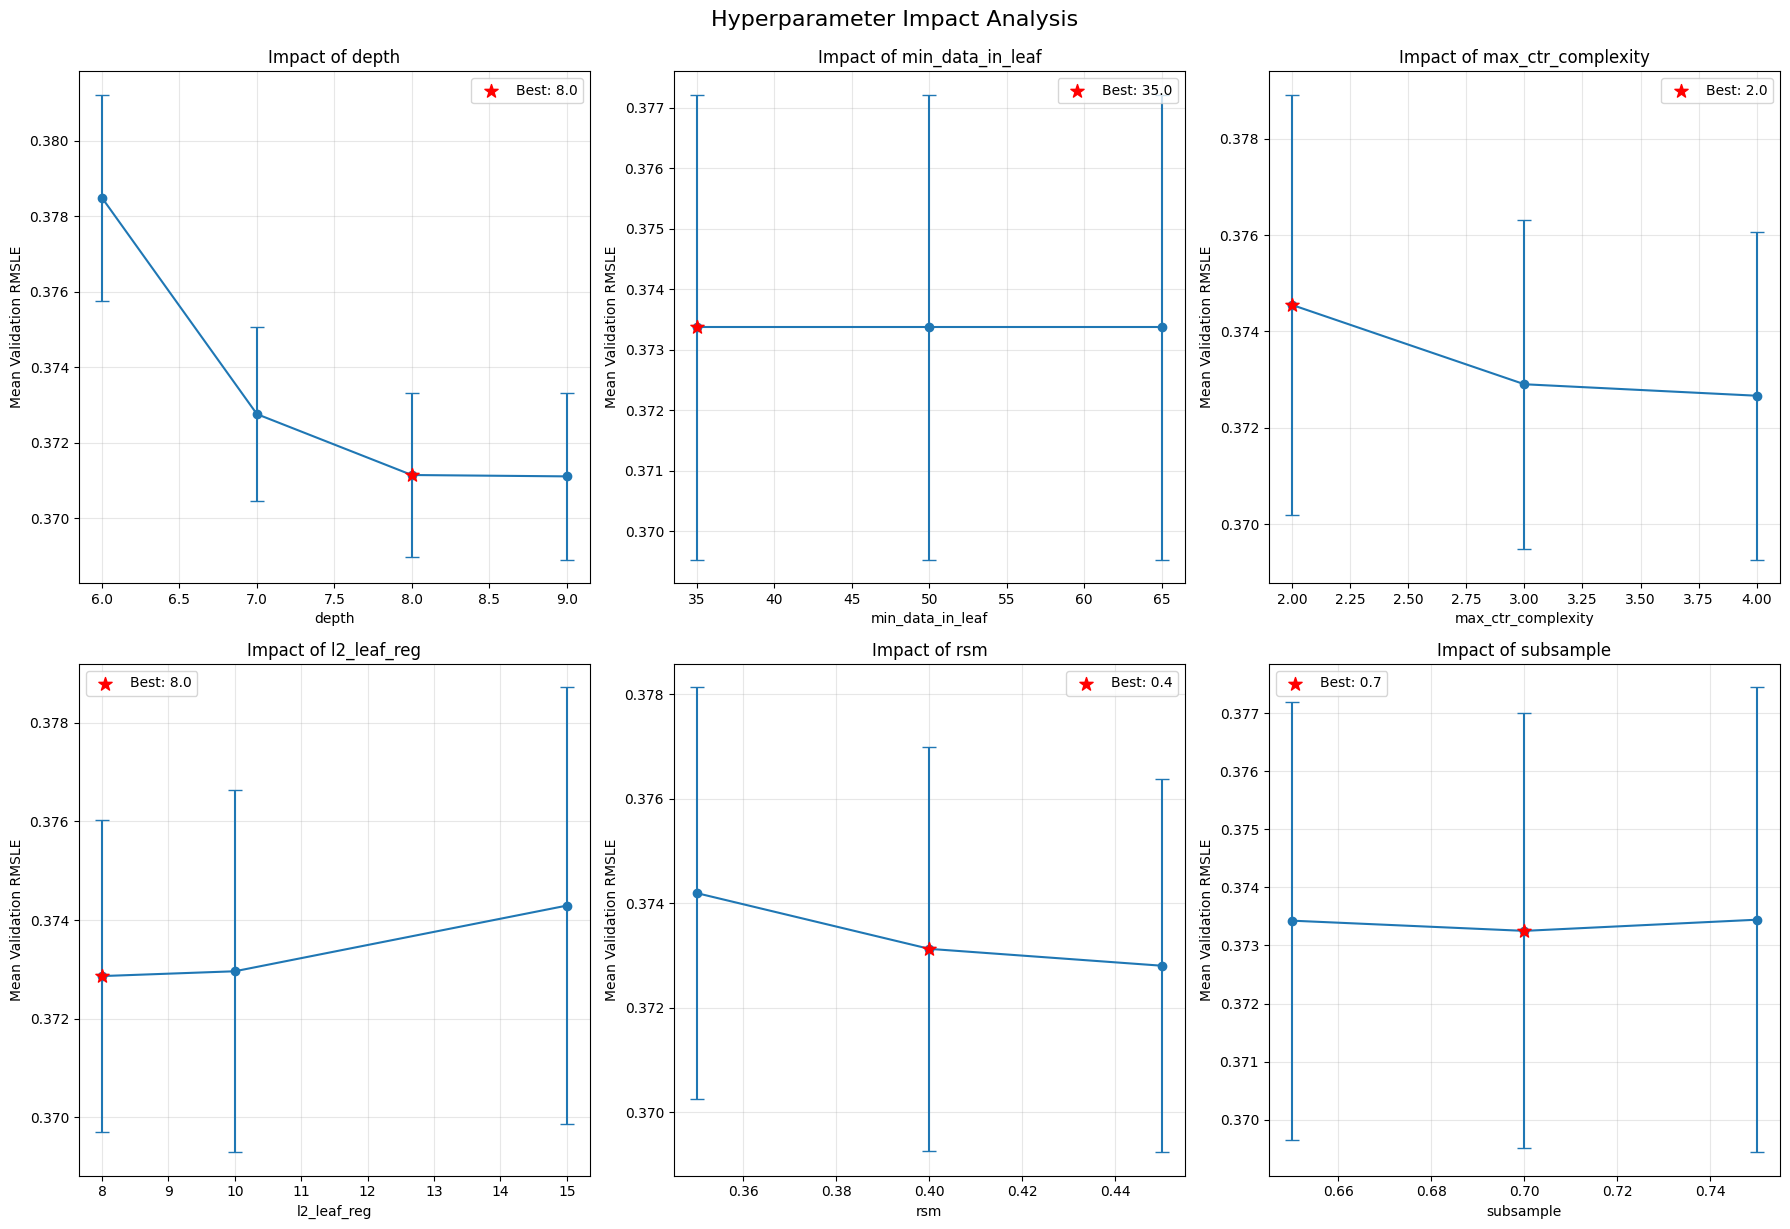


Hyperparameter Impact Summary:
--------------------------------------------------
depth:
  Best value: 9 (RMSLE: 0.3711)
  Worst value: 6 (RMSLE: 0.3785)
  Impact range: 0.0074

min_data_in_leaf:
  Best value: 35 (RMSLE: 0.3734)
  Worst value: 35 (RMSLE: 0.3734)
  Impact range: 0.0000

max_ctr_complexity:
  Best value: 4 (RMSLE: 0.3727)
  Worst value: 2 (RMSLE: 0.3746)
  Impact range: 0.0019

l2_leaf_reg:
  Best value: 8 (RMSLE: 0.3729)
  Worst value: 15 (RMSLE: 0.3743)
  Impact range: 0.0014

rsm:
  Best value: 0.45 (RMSLE: 0.3728)
  Worst value: 0.35 (RMSLE: 0.3742)
  Impact range: 0.0014

subsample:
  Best value: 0.7 (RMSLE: 0.3733)
  Worst value: 0.75 (RMSLE: 0.3734)
  Impact range: 0.0002



In [21]:
# Analyze hyperparameter impact
import matplotlib.pyplot as plt
import seaborn as sns

# Create hyperparameter impact analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

hyperparams = ['depth', 'min_data_in_leaf', 'max_ctr_complexity', 'l2_leaf_reg', 'rsm', 'subsample']

for i, param in enumerate(hyperparams):
    # Group by parameter value and calculate mean RMSLE
    param_impact = results_df.groupby(param)['val_rmsle'].agg(['mean', 'std', 'count']).reset_index()
    
    axes[i].errorbar(param_impact[param], param_impact['mean'], 
                     yerr=param_impact['std'], marker='o', capsize=5)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Mean Validation RMSLE')
    axes[i].set_title(f'Impact of {param}')
    axes[i].grid(True, alpha=0.3)
    
    # Highlight best value
    best_value = best_params[param]
    best_rmsle = param_impact[param_impact[param] == best_value]['mean'].iloc[0]
    axes[i].scatter([best_value], [best_rmsle], color='red', s=100, marker='*', 
                   label=f'Best: {best_value}', zorder=5)
    axes[i].legend()

plt.tight_layout()
plt.suptitle('Hyperparameter Impact Analysis', fontsize=16, y=1.02)
plt.show()

print("\nHyperparameter Impact Summary:")
print("-" * 50)
for param in hyperparams:
    param_impact = results_df.groupby(param)['val_rmsle'].mean()
    best_val = param_impact.idxmin()
    worst_val = param_impact.idxmax()
    impact_range = param_impact.max() - param_impact.min()
    
    print(f"{param}:")
    print(f"  Best value: {best_val} (RMSLE: {param_impact[best_val]:.4f})")
    print(f"  Worst value: {worst_val} (RMSLE: {param_impact[worst_val]:.4f})")
    print(f"  Impact range: {impact_range:.4f}")
    print()

### Train cb_80_100 Model on Full Training Data

Now let's train cb_80_100 using all available training data (train + validation) which represents ~80% of our original data.

In [25]:
# Combine train and validation data for cb_80_100 model
X_train_full = pd.concat([X_train_log, X_val_log], axis=0)
y_train_full = pd.concat([y_train_log, y_val_log], axis=0)

print(f"cb_80_100 training data shape: {X_train_full.shape}")
print(f"Original train: {len(X_train_log)}, validation: {len(X_val_log)}, combined: {len(X_train_full)}")

# Use test_log as validation for early stopping in cb_80_100 model
X_final_val = X_test_log
y_final_val = y_test_log

cb_80_100 training data shape: (8708, 23)
Original train: 6531, validation: 2177, combined: 8708


In [26]:
# Train cb_80_100 model with more training data
print("Training cb_80_100 CatBoost model with combined train+val data...")

# Initialize cb_80_100 model with same parameters
cb_80_100 = CatBoostRegressor(**catboost_params)

# Train on combined data using test_log for early stopping
cb_80_100.fit(
    X_train_full, 
    y_train_full,
    eval_set=(X_final_val, y_final_val),
    cat_features=cat_features_indices,
    use_best_model=True,
    plot=False
)

print(f"cb_80_100 training completed! Stopped at iteration: {cb_80_100.get_best_iteration()}")

# Compare cb_80_100 model performance on test set
cb_80_100_test_predictions_log = cb_80_100.predict(X_test_log)
cb_80_100_test_rmse_log = np.sqrt(mean_squared_error(y_test_log, cb_80_100_test_predictions_log))

# Calculate RMSLE for cb_80_100
cb_80_100_test_predictions_original = data_process.inverse_log_transform(cb_80_100_test_predictions_log)
cb_80_100_test_targets_original = data_process.inverse_log_transform(y_test_log)
cb_80_100_test_rmsle = rmsle(cb_80_100_test_targets_original, cb_80_100_test_predictions_original)

print(f"\nModel Comparison on Test Set:")
print(f"cb_60_100 RMSE: {cb_60_100_results['test_rmse_log']:.4f}")
print(f"cb_80_100 RMSE: {cb_80_100_test_rmse_log:.4f}")
print(f"Improvement: {((cb_60_100_results['test_rmse_log'] - cb_80_100_test_rmse_log) / cb_60_100_results['test_rmse_log'] * 100):.2f}%")

# Store results for cb_80_100
cb_80_100_results = {
    'best_iteration': cb_80_100.get_best_iteration(),
    'test_rmse_log': cb_80_100_test_rmse_log,
    'test_rmsle': cb_80_100_test_rmsle
}

Training cb_80_100 CatBoost model with combined train+val data...
0:	learn: 1.4094512	test: 1.4077665	best: 1.4077665 (0)	total: 6.09ms	remaining: 1m 31s
1000:	learn: 0.3634999	test: 0.3635367	best: 0.3635367 (1000)	total: 5.02s	remaining: 1m 10s
1000:	learn: 0.3634999	test: 0.3635367	best: 0.3635367 (1000)	total: 5.02s	remaining: 1m 10s
2000:	learn: 0.3166553	test: 0.3337477	best: 0.3337477 (2000)	total: 10.4s	remaining: 1m 7s
2000:	learn: 0.3166553	test: 0.3337477	best: 0.3337477 (2000)	total: 10.4s	remaining: 1m 7s
3000:	learn: 0.2877794	test: 0.3205280	best: 0.3205280 (3000)	total: 15.7s	remaining: 1m 2s
3000:	learn: 0.2877794	test: 0.3205280	best: 0.3205280 (3000)	total: 15.7s	remaining: 1m 2s
4000:	learn: 0.2658788	test: 0.3128744	best: 0.3128744 (4000)	total: 21s	remaining: 57.7s
4000:	learn: 0.2658788	test: 0.3128744	best: 0.3128744 (4000)	total: 21s	remaining: 57.7s
5000:	learn: 0.2475269	test: 0.3078409	best: 0.3078409 (5000)	total: 26.5s	remaining: 53s
5000:	learn: 0.2475269

In [27]:
# Make cb_80_100 predictions for Kaggle submission
cb_80_100_kaggle_predictions_log = cb_80_100.predict(X_test_kaggle)
cb_80_100_kaggle_predictions = data_process.inverse_log_transform(cb_80_100_kaggle_predictions_log)

print(f"cb_80_100 Kaggle predictions range: {cb_80_100_kaggle_predictions.min():.2f} to {cb_80_100_kaggle_predictions.max():.2f}")

# Create cb_80_100 submission file
submission_cb_80_100 = pd.read_csv('input/sampleSubmission.csv')
submission_cb_80_100["count"] = cb_80_100_kaggle_predictions
submission_cb_80_100.to_csv("submissions/submission_cb_80_100_laggs.csv", index=False)

print("cb_80_100 submission saved to submissions/submission_cb_80_100_laggs.csv")

# Compare prediction ranges
print(f"\nPrediction Comparison:")
print(f"cb_60_100 range: {test_predictions_kaggle.min():.2f} to {test_predictions_kaggle.max():.2f}")
print(f"cb_80_100 range: {cb_80_100_kaggle_predictions.min():.2f} to {cb_80_100_kaggle_predictions.max():.2f}")

cb_80_100 Kaggle predictions range: 0.79 to 822.17
cb_80_100 submission saved to submissions/submission_cb_80_100_laggs.csv

Prediction Comparison:
cb_60_100 range: 1.27 to 863.84
cb_80_100 range: 0.79 to 822.17


### Train cb_100_100 Model with Optimal Trees

Train final model using 100% of training data and the maximum optimal iteration count from the previous models.

In [28]:
# Determine the maximum optimal iteration count from previous models
max_optimal_iterations = max(cb_60_100_results['best_iteration'], cb_80_100_results['best_iteration'])

print("Model Performance Summary:")
print(f"cb_60_100: {cb_60_100_results['best_iteration']} iterations, RMSLE: {cb_60_100_results['test_rmsle']:.4f}")
print(f"cb_80_100: {cb_80_100_results['best_iteration']} iterations, RMSLE: {cb_80_100_results['test_rmsle']:.4f}")
print(f"\nUsing {max_optimal_iterations} iterations for cb_100_100")

# Use all available training data (including test_log) for cb_100_100
X_train_all = pd.concat([X_train_log, X_val_log, X_test_log], axis=0)
y_train_all = pd.concat([y_train_log, y_val_log, y_test_log], axis=0)

print(f"\ncb_100_100 training data shape: {X_train_all.shape}")
print(f"Total training samples: {len(X_train_all)} (100% of available data)")

Model Performance Summary:
cb_60_100: 6539 iterations, RMSLE: 0.3072
cb_80_100: 9465 iterations, RMSLE: 0.2980

Using 9465 iterations for cb_100_100

cb_100_100 training data shape: (10886, 23)
Total training samples: 10886 (100% of available data)


In [29]:
# Train cb_100_100 model with optimal iterations and all data
print("Training cb_100_100 CatBoost model with 100% data and optimal iterations...")

# Create parameters for cb_100_100 with fixed iterations
cb_100_100_params = catboost_params.copy()
cb_100_100_params['iterations'] = max_optimal_iterations
# Remove early stopping since we're using optimal iterations
cb_100_100_params.pop('od_type', None)
cb_100_100_params.pop('od_wait', None)

# Initialize cb_100_100 model
cb_100_100 = CatBoostRegressor(**cb_100_100_params)

# Train on all available data without validation set (since we're using optimal iterations)
cb_100_100.fit(
    X_train_all, 
    y_train_all,
    cat_features=cat_features_indices,
    plot=False
)

print(f"cb_100_100 training completed! Used {max_optimal_iterations} iterations on {len(X_train_all)} samples")

Training cb_100_100 CatBoost model with 100% data and optimal iterations...
0:	learn: 1.4092338	total: 6.31ms	remaining: 59.7s
1000:	learn: 0.3614507	total: 5.38s	remaining: 45.5s
1000:	learn: 0.3614507	total: 5.38s	remaining: 45.5s
2000:	learn: 0.3134894	total: 11.2s	remaining: 41.6s
2000:	learn: 0.3134894	total: 11.2s	remaining: 41.6s
3000:	learn: 0.2873323	total: 16.9s	remaining: 36.3s
3000:	learn: 0.2873323	total: 16.9s	remaining: 36.3s
4000:	learn: 0.2679241	total: 22.6s	remaining: 30.8s
4000:	learn: 0.2679241	total: 22.6s	remaining: 30.8s
5000:	learn: 0.2519437	total: 28.4s	remaining: 25.4s
5000:	learn: 0.2519437	total: 28.4s	remaining: 25.4s
6000:	learn: 0.2383748	total: 34.5s	remaining: 19.9s
6000:	learn: 0.2383748	total: 34.5s	remaining: 19.9s
7000:	learn: 0.2258019	total: 40.6s	remaining: 14.3s
7000:	learn: 0.2258019	total: 40.6s	remaining: 14.3s
8000:	learn: 0.2148852	total: 46.3s	remaining: 8.48s
8000:	learn: 0.2148852	total: 46.3s	remaining: 8.48s
9000:	learn: 0.2046726	to

In [30]:
# Make cb_100_100 predictions for Kaggle submission
cb_100_100_kaggle_predictions_log = cb_100_100.predict(X_test_kaggle)
cb_100_100_kaggle_predictions = data_process.inverse_log_transform(cb_100_100_kaggle_predictions_log)

print(f"cb_100_100 Kaggle predictions range: {cb_100_100_kaggle_predictions.min():.2f} to {cb_100_100_kaggle_predictions.max():.2f}")

# Create cb_100_100 submission file
submission_cb_100_100 = pd.read_csv('input/sampleSubmission.csv')
submission_cb_100_100["count"] = cb_100_100_kaggle_predictions
submission_cb_100_100.to_csv("submissions/submission_cb_100_100_laggs.csv", index=False)

print("cb_100_100 submission saved to submissions/submission_cb_100_100_laggs.csv")

# Final model comparison summary
print(f"\nFinal Model Comparison Summary:")
print("="*50)
print(f"cb_60_100: {cb_60_100_results['best_iteration']} iterations, RMSLE: {cb_60_100_results['test_rmsle']:.4f}")
print(f"cb_80_100: {cb_80_100_results['best_iteration']} iterations, RMSLE: {cb_80_100_results['test_rmsle']:.4f}")
print(f"cb_100_100: {max_optimal_iterations} iterations, trained on 100% data")

print(f"\nPrediction Range Comparison:")
print(f"cb_60_100: {test_predictions_kaggle.min():.2f} to {test_predictions_kaggle.max():.2f}")

# Ensure cb_80_100_kaggle_predictions is defined
if 'cb_80_100_kaggle_predictions' not in locals():
	cb_80_100_kaggle_predictions_log = cb_80_100.predict(X_test_kaggle)
	cb_80_100_kaggle_predictions = data_process.inverse_log_transform(cb_80_100_kaggle_predictions_log)

print(f"cb_80_100: {cb_80_100_kaggle_predictions.min():.2f} to {cb_80_100_kaggle_predictions.max():.2f}")
print(f"cb_100_100: {cb_100_100_kaggle_predictions.min():.2f} to {cb_100_100_kaggle_predictions.max():.2f}")

print(f"\nSubmission files created:")
print("- submissions/submission_cb_60_100_laggs.csv")
print("- submissions/submission_cb_80_100_laggs.csv")
print("- submissions/submission_cb_100_100_laggs.csv")

cb_100_100 Kaggle predictions range: 0.78 to 874.80
cb_100_100 submission saved to submissions/submission_cb_100_100_laggs.csv

Final Model Comparison Summary:
cb_60_100: 6539 iterations, RMSLE: 0.3072
cb_80_100: 9465 iterations, RMSLE: 0.2980
cb_100_100: 9465 iterations, trained on 100% data

Prediction Range Comparison:
cb_60_100: 1.27 to 863.84
cb_80_100: 0.79 to 822.17
cb_100_100: 0.78 to 874.80

Submission files created:
- submissions/submission_cb_60_100_laggs.csv
- submissions/submission_cb_80_100_laggs.csv
- submissions/submission_cb_100_100_laggs.csv


### Feature Importance Analysis for All Models

Analyze and compare feature importance across all three CatBoost models.

In [31]:
# Get feature importance for all three models
import matplotlib.pyplot as plt

# Extract feature importance from all models
feature_names = X_train_log.columns

cb_60_100_importance = cb_60_100.get_feature_importance()
cb_80_100_importance = cb_80_100.get_feature_importance()
cb_100_100_importance = cb_100_100.get_feature_importance()

# Create comprehensive feature importance dataframe
feature_importance_comparison = pd.DataFrame({
    'feature': feature_names,
    'cb_60_100_importance': cb_60_100_importance,
    'cb_80_100_importance': cb_80_100_importance,
    'cb_100_100_importance': cb_100_100_importance
})

# Sort by cb_100_100 importance (descending)
feature_importance_comparison = feature_importance_comparison.sort_values('cb_100_100_importance', ascending=False)

print("Feature Importance Comparison (Top 20 features by cb_100_100):")
print("="*80)
print(feature_importance_comparison.head(20).to_string(index=False, float_format='%.2f'))

# Save to CSV for further analysis
feature_importance_comparison.to_csv("submissions/feature_importance_comparison.csv", index=False)
print(f"\nFeature importance comparison saved to submissions/feature_importance_comparison.csv")

Feature Importance Comparison (Top 20 features by cb_100_100):
        feature  cb_60_100_importance  cb_80_100_importance  cb_100_100_importance
           hour                 23.09                 19.58                  24.25
     log_lag_1d                 17.04                 17.14                  16.47
     log_lag_7d                 10.55                 12.25                  11.76
    log_lag_14d                  6.19                  6.63                   6.02
       is_night                  7.65                  7.18                   5.77
     workingday                  7.54                  6.90                   5.68
      dayofweek                  4.07                  4.93                   5.48
        weather                  3.60                  3.30                   3.45
       humidity                  1.82                  1.98                   2.34
         season                  2.47                  2.55                   2.24
          month         

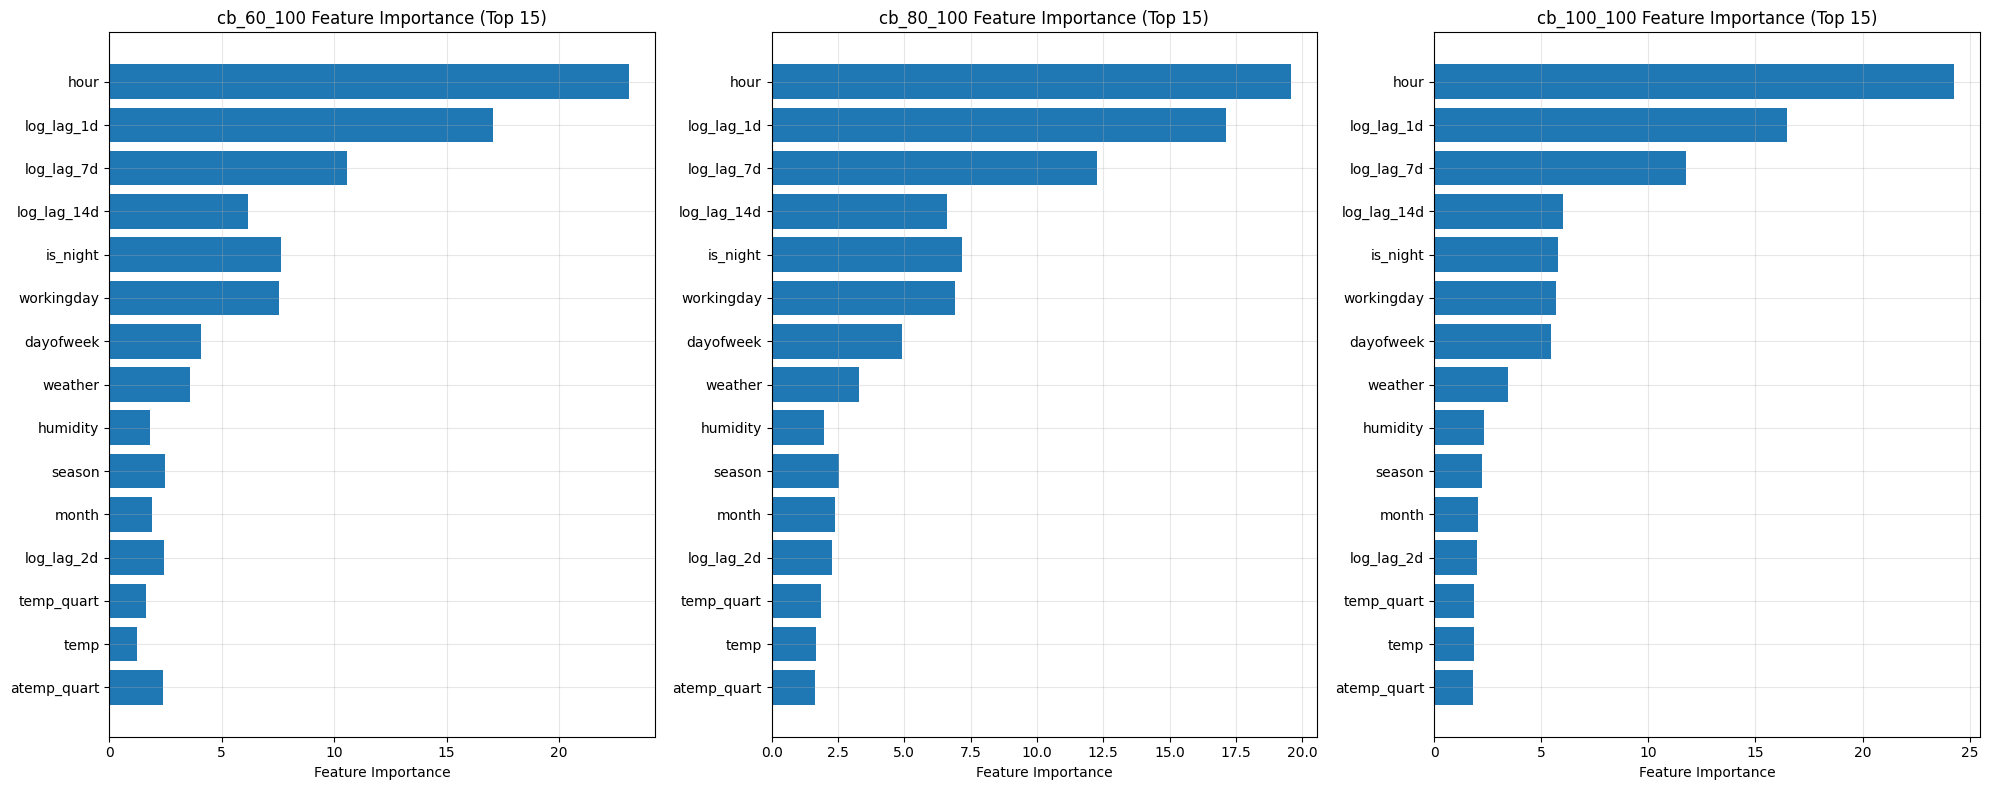


Feature Importance Insights:
Most important feature (cb_100_100): hour
Least variable feature across models: temp_quart
Most variable feature across models: hour

Importance Correlation with cb_100_100:
cb_60_100 vs cb_100_100: 0.991
cb_80_100 vs cb_100_100: 0.984


In [32]:
# Create three separate plots for feature importance comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Get top 15 features based on cb_100_100 importance
top_15_features = feature_importance_comparison.head(15)

# Plot 1: cb_60_100
axes[0].barh(range(15), top_15_features['cb_60_100_importance'][::-1])
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(top_15_features['feature'][::-1])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('cb_60_100 Feature Importance (Top 15)')
axes[0].grid(True, alpha=0.3)

# Plot 2: cb_80_100
axes[1].barh(range(15), top_15_features['cb_80_100_importance'][::-1])
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(top_15_features['feature'][::-1])
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('cb_80_100 Feature Importance (Top 15)')
axes[1].grid(True, alpha=0.3)

# Plot 3: cb_100_100
axes[2].barh(range(15), top_15_features['cb_100_100_importance'][::-1])
axes[2].set_yticks(range(15))
axes[2].set_yticklabels(top_15_features['feature'][::-1])
axes[2].set_xlabel('Feature Importance')
axes[2].set_title('cb_100_100 Feature Importance (Top 15)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional insights
print(f"\nFeature Importance Insights:")
print("="*50)
print(f"Most important feature (cb_100_100): {top_15_features.iloc[0]['feature']}")

# Compute std only across numeric importance columns
importance_cols = ['cb_60_100_importance', 'cb_80_100_importance', 'cb_100_100_importance']
top_15_std = feature_importance_comparison.iloc[:15][importance_cols].std(axis=1)
least_variable_feature = feature_importance_comparison.loc[top_15_std.idxmin(), 'feature']
most_variable_feature = feature_importance_comparison.loc[top_15_std.idxmax(), 'feature']

print(f"Least variable feature across models: {least_variable_feature}")
print(f"Most variable feature across models: {most_variable_feature}")

# Show correlation between model importance rankings
correlation_60_100 = feature_importance_comparison['cb_60_100_importance'].corr(feature_importance_comparison['cb_100_100_importance'])
correlation_80_100 = feature_importance_comparison['cb_80_100_importance'].corr(feature_importance_comparison['cb_100_100_importance'])

print(f"\nImportance Correlation with cb_100_100:")
print(f"cb_60_100 vs cb_100_100: {correlation_60_100:.3f}")
print(f"cb_80_100 vs cb_100_100: {correlation_80_100:.3f}")

### Submit results to Kaggle

In [33]:
!kaggle competitions submit -c bike-sharing-demand -f submissions/submission_cb_60_100_laggs.csv -m "catboost 60% train optimal with laggs"
!kaggle competitions submit -c bike-sharing-demand -f submissions/submission_cb_80_100_laggs.csv -m "catboost 80% train optimal with laggs"
!kaggle competitions submit -c bike-sharing-demand -f submissions/submission_cb_100_100_laggs.csv -m "catboost 100% train optimal with laggs"

100%|████████████████████████████████████████| 244k/244k [00:05<00:00, 44.7kB/s]
100%|████████████████████████████████████████| 244k/244k [00:06<00:00, 41.3kB/s]
100%|████████████████████████████████████████| 244k/244k [00:05<00:00, 49.7kB/s]
Successfully submitted to Bike Sharing Demand

In [34]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                        description                                status                     publicScore  privateScore  
-------------------------------  --------------------------  -----------------------------------------  -------------------------  -----------  ------------  
submission_cb_100_100_laggs.csv  2025-07-29 14:29:21.103000  catboost 100% train optimal with laggs     SubmissionStatus.COMPLETE  0.43496      0.43496       
submission_cb_80_100_laggs.csv   2025-07-29 14:29:13.813000  catboost 80% train optimal with laggs      SubmissionStatus.COMPLETE  0.44340      0.44340       
submission_cb_60_100_laggs.csv   2025-07-29 14:29:04         catboost 60% train optimal with laggs      SubmissionStatus.COMPLETE  0.43764      0.43764       
submission_cb_100_100.csv        2025-07-29 07:00:27         catboost 100% train optimal                SubmissionStatus.COMPLETE  0.45705      0.45705       
